Module 3, Lab 2 - Association
=============================

In this lab, we will examine how to analyze data for a correlation. Note
that a detailed dive into correlational and regression-based research is
given in Module 5. However, a brief overview is provided here. I focus
on correlation because it is the simplest way to make an association
claim, but as we saw in the online lesson, actually the correct analysis
depends on your data (continuous, discrete, normal vs non-normal, etc.).
Thus, a full illustration of all association techniques would take many,
many labs. I focus on correlation here.

In this example, you are analyzing customer loyalty data. Your
organization uses three measures of loyalty, and you wish to test them
out. (To avoid discussions of popular real measures, we will name these
`loytalty1`, `loyalty2`, and `loyalty3`).

Note that this lab uses the `ggplot2` package for data visualization and
the `psych` package for correlation testing. I also assume you are
familiar with `ggplot2`. As an alternative to the `psych` tools, we can
also use the `Hmisc` package for correlation testing.

In [1]:
#### LOAD PACKAGES ####
## Use inline magic command so plots appear in the data frame
%matplotlib inline

## Next the packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as ss
import math

You load the data from the CSV file in the github folder for this lab:

In [2]:
#### LOAD DATA ####
dat = pd.read_csv("datasets/loyaltydata.csv")

You inspect the data:

In [3]:
print(dat.columns)

dat.head()

Index(['Unnamed: 0', 'loyalty1', 'loyalty2', 'loyalty3'], dtype='object')


,Unnamed: 0,loyalty1,loyalty2,loyalty3
0,1,9,10,4
1,2,10,11,5
2,3,10,10,5
3,4,9,10,5
4,5,8,11,4


There is an ID variable shown as `Unnamed` and scores on a loyalty measures named
`loyalty1` through `loyalty3`. 

****
**Note:** You are not yet familiar with the scaling of these measures.
***

The first thing to do is to explore the variables. The Pandas `describe()` method.

In [4]:
dat.describe()

,Unnamed: 0,loyalty1,loyalty2,loyalty3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,9.960000,10.449000,5.072000
std,288.819436,1.043786,1.332357,1.045901
min,1.000000,7.000000,7.000000,2.000000
25%,250.750000,9.000000,10.000000,4.000000
50%,500.500000,10.000000,10.000000,5.000000
75%,750.250000,11.000000,11.000000,6.000000
max,1000.000000,13.000000,16.000000,8.000000


This gives you a sense as to the range and scaling of each loyalty
measure.

Imagine that each loyalty measure was in common use. You might want to
know whether they are highly correlated. We can compute correlations
between variables with the Pandas `corr()` method. A subset of the data frame is taken (using the outer `[]` operator) by providing a list (the inner `[]`) of column names.

In [5]:
dat[['loyalty1', 'loyalty2', 'loyalty3']].corr()

,loyalty1,loyalty2,loyalty3
loyalty1,1.000000,0.395853,0.498695
loyalty2,0.395853,1.000000,0.573709
loyalty3,0.498695,0.573709,1.000000


This difficult to read. Let's use the Pandas `round()` method:

In [6]:
corr_mat = dat[['loyalty1', 'loyalty2', 'loyalty3']].corr().round(2)
corr_mat

,loyalty1,loyalty2,loyalty3
loyalty1,1.0,0.40,0.50
loyalty2,0.4,1.00,0.57
loyalty3,0.5,0.57,1.00


We see here that the variables are *not* highly correlated with each
other. This is a potential problem.

A brief refresher: correlations range between zero (no association
between variables) and 1.0 (a one-to-one association). They can also be
positive (as one variable increases, so does the other) or negative (as
one variable increases, the other decreases).

The statistician Jacob Cohen suggested the following guidelines:  

<pre>
| # | Correlation |  Meaning   |
|---|-------------|------------|
| 1 |  0.0 - 0.1  | Negligible |
| 2 |  0.1 - 0.3  |   Small    |
| 3 |  0.3 - 0.5  |   Medium   |
| 4 |    0.5 +    |   Large    |
</pre>

However, given that they are all ostensibly measuring the same thing,
loyalty, we should expect much higher correlations (.7-.9).

We can also easily visualize this correlation with using the `heatmap` function from the Python Seaborn package. Seaborn is a sophisticated statistical charting package. 

(array([0.5, 1.5, 2.5]), <a list of 3 Text xticklabel objects>)

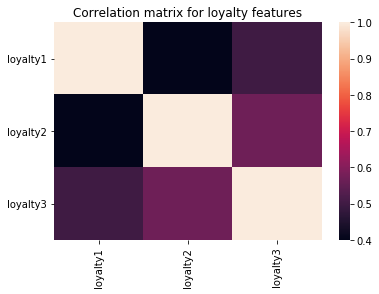

In [7]:
sns.heatmap(corr_mat, vmax=1.0) 
plt.title('Correlation matrix for loyalty features')
plt.yticks(rotation='horizontal')
plt.xticks(rotation='vertical')

Next, you will create scatter plots of each pairwise combination of loyalty variables. The code uses the `lmplot` function from Seaborn. Jitter on both the x and y axes along with high point transparency are used to help deal with over-plotting. Notice that the transparency argument, `alpha`, must be passed to the underling Matplotlib in a dictionary called `scatter_kws`. 

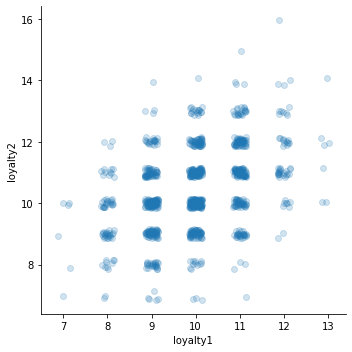

In [8]:
sns.lmplot("loyalty1", "loyalty2", dat, x_jitter=.15, y_jitter=.15, scatter_kws={'alpha':0.2}, fit_reg = False)

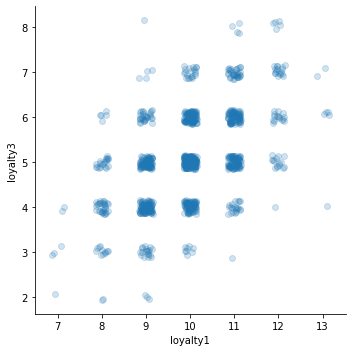

In [9]:
sns.lmplot("loyalty1", "loyalty3", dat, x_jitter=.15, y_jitter=.15, scatter_kws={'alpha':0.2}, fit_reg = False)

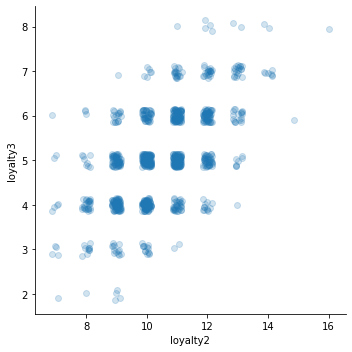

In [10]:
sns.lmplot("loyalty2", "loyalty3", dat, x_jitter=.15, y_jitter=.15, scatter_kws={'alpha':0.2}, fit_reg = False)

![](Mod3_Lab2_-_Association_files/figure-markdown_strict/unnamed-chunk-8-1.png)

![](Mod3_Lab2_-_Association_files/figure-markdown_strict/unnamed-chunk-8-3.png)
All of the graphs look about the same. It is always good to inspect the
plots, as we know that non-linearity can weaken our correlations. Here,
we see evidence that each measure is correlated linearly; the
associations are simply underwhelming.

![](Mod3_Lab2_-_Association_files/figure-markdown_strict/unnamed-chunk-9-1.png)

We can easily compute the confidence intervals of these correlation coefficients. However, this requires a few steps (don't worry if you don't follow this completely:   
1. Transform the correlation from the initial space which we call r to a transformed space z. The distribution of errors is Normal in this transformed space. 
2. Compute the CI in the transformed space.
3. Transform back to the original space.

In [11]:
def r_z(r):
    return math.log((1 + r) / (1 - r)) / 2.0

def z_r(z):
    e = math.exp(2 * z)
    return((e - 1) / (e + 1))

def r_conf_int(r, alpha, n):
    # Transform r to z space
    z = r_z(r)
    # Compute standard error and critcal value in z
    se = 1.0 / math.sqrt(n - 3)
    z_crit = ss.norm.ppf(1 - alpha/2)

    ## Compute CIs with transform to r
    lo = z_r(z - z_crit * se)
    hi = z_r(z + z_crit * se)
    return (lo, hi)

print('\nFor loyalty1 vs. loyalty2')
corr_mat = np.array(corr_mat)
conf_ints = r_conf_int(corr_mat[1,0], 0.05, 1000)
print('Correlation = %4.3f with CI of %4.3f to %4.3f' % (corr_mat[1,0], conf_ints[0], conf_ints[1]))
print('\nFor loyalty1 vs. loyalty3')
conf_ints = r_conf_int(corr_mat[2,0], 0.05, 1000)
print('Correlation = %4.3f with CI of %4.3f to %4.3f' % (corr_mat[2,0], conf_ints[0], conf_ints[1]))
print('\nFor loyalty2 vs. loyalty3')
conf_ints = r_conf_int(corr_mat[2,1], 0.05, 1000)
print('Correlation = %4.3f with CI of %4.3f to %4.3f' % (corr_mat[2,1], conf_ints[0], conf_ints[1]))


For loyalty1 vs. loyalty2
Correlation = 0.400 with CI of 0.347 to 0.451

For loyalty1 vs. loyalty3
Correlation = 0.500 with CI of 0.452 to 0.545

For loyalty2 vs. loyalty3
Correlation = 0.570 with CI of 0.527 to 0.610


You can see that the CIs of all the correlation coefficients are relatively small compared to the correlation coefficients. This indicates that these coefficients are statistically significant.

What Claims Can We Make?
========================

Here, we can make the following claims: each of these variables is
correlated with each other, but in reality, the correlations are weaker
than you would hope them to be. In this case, we can have a series of
conversations about whether these measures of loyalty are assessing
different things, whether there are actually different kinds of customer
loyalty, or whether the measures are not of high quality. Regardless,
there appears to *not* be a large association between our measures of
loyalty. In fact, using 95% CIs, we found that we had fairly precise
estimate of our correlations: they are not strong. This raises large
implications for our organization as it considers using these measures.